## Imports and Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
import torch
from torch import nn
from torch.nn.functional import interpolate
from torch.utils.data import DataLoader

## Part 1: Data Geneneration

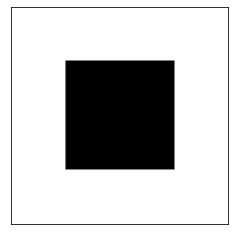

In [2]:
#Lets start by just have a data object that is a simple square
H=W=256
canvas = np.zeros([256,256])
canvas[64:256-64,64:256-64] = 1.0
plt.imshow(canvas,cmap='gray_r')
plt.xticks([]);plt.yticks([]);

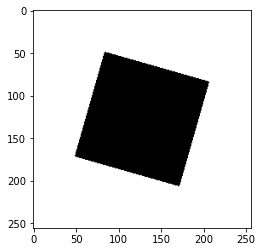

In [3]:
#rotations https://stackoverflow.com/a/18683594
def rotate_img(img,save_deg=False, deg=None):
    if deg == None:
        deg = np.random.randint(0,360)
    if not save_deg:
        return (ndimage.rotate(img, deg,axes = (-2,-1), reshape=False))>.5
    else:
        return (ndimage.rotate(img, deg,axes = (-2,-1), reshape=False))>.5, de
plt.imshow(rotate_img(canvas),cmap='gray_r')
rotated = rotate_img(canvas)

In [4]:
#Some plotting code
def add_axis_grid(ax,H,W,R):
    #https://stackoverflow.com/questions/38973868/adjusting-gridlines-and-ticks-in-matplotlib-imshow
    # Major ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Labels for major ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Minor ticks
    ax.set_xticks(np.arange(-.5, W, R), minor=True)
    ax.set_yticks(np.arange(-.5, H, R), minor=True)
    
    # Gridlines based on minor ticks
    ax.grid(which='minor', color='b', linestyle='-', linewidth=1)

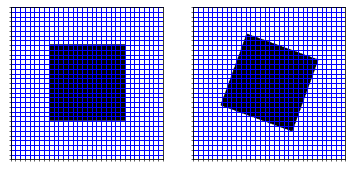

In [5]:
R = 8
plt.subplot(121)
plt.imshow(canvas,cmap='gray_r')
add_axis_grid(plt.gca(),H,W,R)
plt.subplot(122)
plt.imshow(rotated,cmap='gray_r')
add_axis_grid(plt.gca(),H,W,R)

### Getting image patches into point cloud format

In [6]:
#Some code for getting nonoverlapping patches
psz=16
img_patches = nn.Unfold(psz, psz)(torch.tensor(rotated>.5).to(torch.float64).view(1,1,H,W)).view(-1, int(H/psz), int(W/psz))

In [7]:
psz=16
img_patches = nn.Unfold(psz, psz)(torch.tensor(rotated>.5).to(torch.float64).view(1,1,H,W)).view(-1, int(H/psz), int(W/psz))
R = 8
xs = torch.arange(R).to(torch.float64)
ys = torch.arange(R).to(torch.float64)
grid_x, grid_y = torch.meshgrid(xs, ys, indexing='ij')
grid_x = grid_x.flatten().view(1,1,-1).expand(img_patches.shape[0],-1,-1)
grid_y = grid_y.flatten().view(1,1,-1).expand(img_patches.shape[0],-1,-1)

In [8]:
interp = interpolate(img_patches.unsqueeze(0), size=[8,8]).view(img_patches.shape[0],-1,R**2)

In [9]:
interp = interpolate(img_patches.unsqueeze(0), size=[8,8]).view(img_patches.shape[0],-1,R**2)
point_cloud = torch.cat([grid_x,grid_y,interp],dim=1)

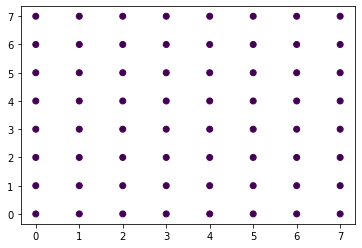

In [10]:
plt.scatter(point_cloud[85,0,:],point_cloud[85,1,:],c=point_cloud[85,2,:])

### Using the "Animals" Dataset

In [11]:
# https://sites.google.com/site/xiangbai/animaldataset
import os
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [12]:
H=W=256
transform_list = transforms.Compose([
    transforms.Resize([int(H*5/8),int(W*5/8)]),
    transforms.Pad([int(H*3/16),int(W*3/16)]),
    transforms.Grayscale(),
    transforms.ToTensor()])
dataset=datasets.ImageFolder(root="./non_rigid_shape_A/",transform=transform_list)


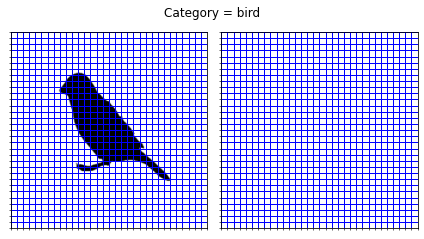

In [13]:
test_img = dataset[0][0].permute(1,2,0)
plt.subplot(121)
plt.imshow(test_img,cmap='gray_r')
add_axis_grid(plt.gca(),H,W,R)
plt.subplot(122)
plt.imshow(rotate_img(test_img),cmap='gray_r')
add_axis_grid(plt.gca(),H,W,R)
plt.tight_layout(rect=[0, 0, 1, 1.1])
plt.suptitle(f'Category = {dataset.classes[dataset[0][1]]}');


In [14]:
from torch.utils.data import DataLoader
train_set, test_set = torch.utils.data.random_split(dataset, [int(len(dataset)*4/5), int(len(dataset)*1/5)])
train_dataloader = DataLoader(train_set, batch_size=50, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=50, shuffle=True)

In [15]:
#function here : make pointclouds ->
def make_pointclouds(imgs,psz=16,R=8):
    '''
    Takes in tensors of size [bsz,1,H,W]
    Returns output of size [bsz,H/psz*W/psz (Number of patches),R**2,3]
    '''
    bsz,_,H,W = imgs.shape
    img_patches = nn.Unfold(psz, psz)((imgs>.5).to(torch.float64).view(bsz,1,H,W)).view(bsz,-1, int(H/psz), int(W/psz))
    xs = torch.arange(R).to(torch.float64).to(imgs.device)
    ys = torch.arange(R).to(torch.float64).to(imgs.device)
    grid_x, grid_y = torch.meshgrid(xs, ys, indexing='ij')
    # Repeat the coordinate information for each batch and patch
    grid_x = grid_x.flatten().view(1,1,-1).expand(img_patches.shape[0],img_patches.shape[1],-1).unsqueeze(-1)
    grid_y = grid_y.flatten().view(1,1,-1).expand(img_patches.shape[0],img_patches.shape[1],-1).unsqueeze(-1)
    interp = interpolate(img_patches, size=[8,8]).view(img_patches.shape[0],-1,R**2).unsqueeze(-1)
    point_cloud = torch.cat([grid_x,grid_y,interp],dim=-1).to(torch.float)
    return point_cloud

## Part 2: Modelling

In [16]:
# Create an embedder with vector neurons
# Where I am at right now: I have created a torch dataset that has all of the images that I want in there
# I have also created a couple of lines of code that will take an image and turn it into a point cloud
# I need to see if I can make this work for a group of images in a batch and how to batch images for a dataloader
# After this I work on modeling, which is basically seeing if I can get an implementation of vnn working before anything else

from models.vn_layers import VNLinearLeakyReLU,VNLinear
from models.vn_pointnet import PointNetEncoder

In [17]:
# Implement vnn code 
# Couple of vnn layers with a linear dimension... after this linear dimension apply traditional apporaches like mlp for prediction
# Train end to end model on classification task 
# Basic batch classification on the outputs of the model

class VN_encoder(nn.Module):
    def __init__(self,out_dim=32):
        super(VN_encoder, self).__init__()
        self.layer1 = VNLinearLeakyReLU(64,32,dim=5)
        self.layer2 = VNLinearLeakyReLU(32,16,dim=4)
        self.layer3 = VNLinear(16,out_dim)
    def forward(self,x):
        x = self.layer1(x)
        return self.layer3(self.layer2(x)).permute(0,3,1,2)

class MLP_encoder(nn.Module):
    def __init__(self,out_dim=32):
        super(MLP_encoder, self).__init__()
        self.layer1 = nn.Sequential(*[nn.Linear(64*3,32*3),nn.LeakyReLU()])
        self.layer2 = nn.Sequential(*[nn.Linear(32*3,16*3),nn.LeakyReLU()])
        self.layer3 = nn.Linear(16*3,out_dim*3)
        
    def forward(self,x):
        x = x.permute(0,3,1,2)
        x = x.reshape(x.shape[0],x.shape[1],-1)
        x = self.layer1(x)
        return self.layer3(self.layer2(x))
    
class MLP_decoder(nn.Module):
    def __init__(self,in_dim=32,N=256):
        super(MLP_decoder, self).__init__()
        emb_dim = in_dim*3 #8*3
        self.layer1 = nn.Sequential(*[nn.Linear(N*emb_dim,N*8),nn.LeakyReLU()])
        self.layer2 = nn.Sequential(*[nn.Linear(N*8,N),nn.LeakyReLU()])
        self.layer3 = nn.Sequential(*[nn.Linear(N,N),nn.ReLU(),nn.Linear(N,10)])
    
    def forward(self,x):
        x = x.reshape(x.shape[0],-1)
        x = self.layer1(x)
        return self.layer3(self.layer2(x))

class Transformer_decoder(nn.Module):
    def __init__(self,in_dim=32, N=256):
        super(Transformer_decoder,self).__init__()
        emb_dim = in_dim*3 #8*3
        self.decoder_layer1 = nn.TransformerEncoderLayer(emb_dim,nhead=4)
        self.decoder_layer2 = nn.TransformerEncoderLayer(emb_dim,nhead=4)
        self.readout = nn.Linear(emb_dim*N,10)
        
    def forward(self,x):
        x = x.reshape(x.shape[0],x.shape[1],-1)
        x = self.decoder_layer1(x)
        x = self.decoder_layer2(x)
        return self.readout(x.reshape(x.shape[0],-1))
    

In [ ]:
# enc_model = MLP_encoder().to('cuda:0')
# dec_model = Transformer_decoder().to('cuda:0')
# optim = optim = torch.optim.Adam(list(enc_model.parameters()) + list(dec_model.parameters()), lr=1e-5, betas=(0.9, 0.96), weight_decay=4.5e-2)
# lossfn = nn.CrossEntropyLoss()
# all_loss = []
# all_acc = []
# all_test_acc = []
for epoch in range(500):
    epoch_loss = 0
    acc_list = []
    for i,batch in enumerate(train_dataloader):
        imgs,labels = batch
        rot_imgs = torch.tensor(rotate_img(imgs))
        rot_imgs = rot_imgs.to('cuda:0'); labels = labels.to('cuda:0')
        pcs= make_pointclouds(rot_imgs)
        encoding = enc_model(pcs.permute(0,2,3,1))
        pred_labels = dec_model(encoding)
        loss = lossfn(pred_labels,labels.to(torch.long))
        epoch_loss += loss.detach().item()
        loss.backward()
        optim.step()
        optim.zero_grad()
        acc_list.append(torch.mean((pred_labels.argmax(1) == labels).cpu().to(torch.float)))
        test_acc_list = []
        for i,batch in enumerate(train_dataloader):
            imgs,labels = batch
            rot_imgs = torch.tensor(rotate_img(imgs))
            rot_imgs = rot_imgs.to('cuda:0'); labels = labels.to('cuda:0')
            pcs= make_pointclouds(rot_imgs)
            with torch.no_grad():
                encoding = enc_model(pcs.permute(0,2,3,1))
                pred_labels = dec_model(encoding)
            test_acc_list.append(torch.mean((pred_labels.argmax(1) == labels).cpu().to(torch.float)))
        all_test_acc.append(np.mean(test_acc_list))

    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, loss = {epoch_loss}, training accuracy = {np.mean(acc_list)}, test accuracy = {np.mean(test_acc_list)}')
    all_loss.append(epoch_loss)
    all_acc.append(np.mean(acc_list))

Epoch: 0, loss = 28.528037428855896, training accuracy = 0.3799999952316284, test accuracy = 0.3974999785423279
Epoch: 10, loss = 28.318970203399658, training accuracy = 0.3824999928474426, test accuracy = 0.39250001311302185
Epoch: 20, loss = 28.202065348625183, training accuracy = 0.4037500023841858, test accuracy = 0.3974999785423279
Epoch: 30, loss = 28.236778140068054, training accuracy = 0.38999998569488525, test accuracy = 0.4012500047683716


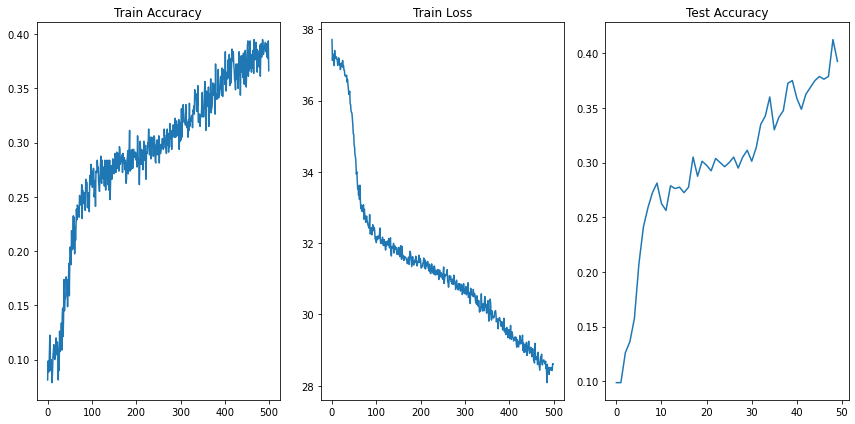

In [27]:
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.plot(all_acc)
plt.title('Train Accuracy')
plt.subplot(132)
plt.plot(all_loss)
plt.title('Train Loss')
plt.subplot(133)
plt.plot(all_test_acc)
plt.title('Test Accuracy')
plt.tight_layout()

In [22]:
print(all_acc[499])

0.36625004


In [29]:
acc_list = []
for i,batch in enumerate(test_dataloader):
    imgs,labels = batch
    imgs = imgs.to('cuda:0'); labels = labels.to('cuda:0')
    pcs= make_pointclouds(imgs)
    with torch.no_grad():
        encoding = enc_model(pcs.permute(0,2,3,1))
        pred_labels = dec_model(encoding)
    acc_list.append(torch.mean((pred_labels.argmax(1) == labels).cpu().to(torch.float)))

In [30]:
np.mean(acc_list)

0.29500002

In [302]:
encoding.shape

torch.Size([50, 256, 32, 3])

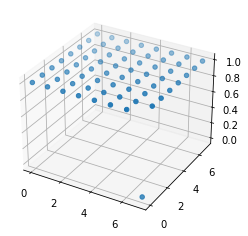

In [303]:
rand_i = np.random.randint(pcs.shape[0])
rand_j = np.random.randint(pcs.shape[1])
test_patch = pcs[rand_i,rand_j,...]
test_patch = test_patch.detach().cpu()
i = 0
while test_patch[:,2].max()==0 :
    i += 1
    np.random.seed(i)
    rand_i = np.random.randint(pcs.shape[0])
    rand_j = np.random.randint(pcs.shape[1])
    test_patch = pcs[rand_i,rand_j,...]
    test_patch = test_patch.detach().cpu()
    
    
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(test_patch[:,0],test_patch[:,1],test_patch[:,2],)

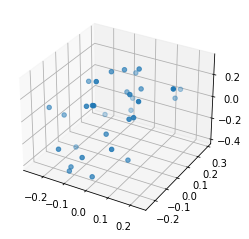

In [304]:
encoding.shape

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(encoding[rand_i,rand_j,:,0].detach().cpu(),encoding[rand_i,rand_j,:,1].detach().cpu(),encoding[rand_i,rand_j,:,2].detach().cpu(),)


In [305]:
test_patch.shape

torch.Size([64, 3])

In [306]:
out_enc = encoding.detach().cpu()
out_enc = out_enc.permute(0,3,1,2)
out_enc = out_enc.reshape(*out_enc.shape[:2],-1).permute(0,2,1)

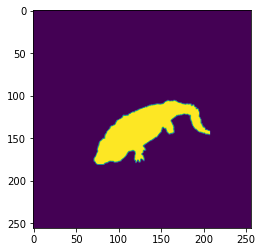

In [307]:
plt.imshow(imgs[0,0,:].cpu())

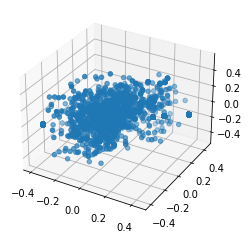

In [308]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(out_enc[0,:,0],out_enc[0,:,1],out_enc[0,:,2])

## Example: A "case study" of the pipeline for a single image

In [309]:
imgs, labels = next(iter(test_dataloader))
test_img = imgs[0,0,...]
label = labels[0]

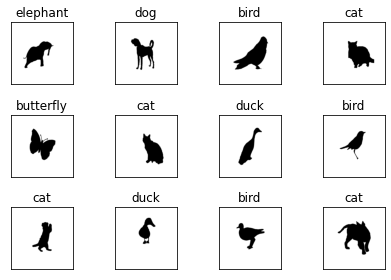

In [310]:
# plt.imshow(test_img)
for i in range(12):
    imgs, labels = next(iter(test_dataloader))
    test_img = imgs[0,0,...]
    label = labels[0]
    plt.subplot(3,4,i+1)
    plt.imshow(test_img,cmap='gray_r')
    plt.xticks([]); plt.yticks([]);
    plt.title(f'{dataset.classes[label]}');
plt.tight_layout();
# add_axis_grid(plt.gca(),H,W,R)
# plt.subplot(122)
# plt.imshow(rotate_img(test_img),cmap='gray_r')
# add_axis_grid(plt.gca(),H,W,R)
# plt.tight_layout(rect=[0, 0, 1, 1.1])
# plt.suptitle(f'Category = {dataset.classes[label]}');

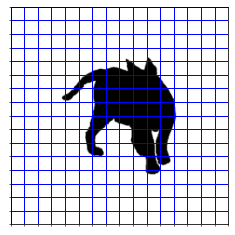

In [311]:
plt.imshow(test_img,cmap='gray_r')
add_axis_grid(plt.gca(),H,W,psz)

In [312]:
# Generate point cloud patches
test_pcs= make_pointclouds(test_img.unsqueeze(0).unsqueeze(0)).squeeze(0).permute(1,2,0)
test_pcs = test_pcs.reshape(*test_pcs.shape[:2],16,16).permute(2,3,0,1) #hard coded atm (int(H/psz))

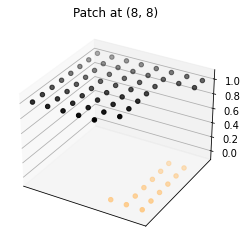

In [313]:
#Plot point cloud patches
rand_i = np.random.randint(test_pcs.shape[0])
rand_j = np.random.randint(test_pcs.shape[1])
test_patch = test_pcs[rand_i,rand_j,...]
i = 0
while test_patch[:,2].max()==0 :
    i += 1
    # np.random.seed(i)
    rand_i = np.random.randint(test_pcs.shape[0])
    rand_j = np.random.randint(test_pcs.shape[1])
    test_patch = test_pcs[rand_i,rand_j,...]
    
    
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(test_patch[:,0],test_patch[:,1],test_patch[:,2],c= test_patch[:,2],cmap='copper_r')
plt.xticks([]);plt.yticks([]);
ax.set_zlim(-.1,1.1)
plt.title(f'Patch at {rand_i,rand_j}');

In [314]:
pcs= make_pointclouds(test_img.unsqueeze(0).unsqueeze(0).cuda())
with torch.no_grad():
    encoding = enc_model(pcs.permute(0,2,3,1))
    pred_labels = dec_model(encoding)

print(torch.mean((pred_labels.argmax(1) == label).cpu().to(torch.float)))

tensor(0.)


In [315]:
dataset.classes[pred_labels.argmax(1)]

'cow'

In [318]:
out_enc.shape

torch.Size([50, 8192, 3])

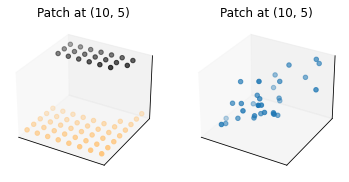

In [320]:
test_pcs= make_pointclouds(test_img.unsqueeze(0).unsqueeze(0)).squeeze(0).permute(1,2,0)
test_pcs = test_pcs.reshape(*test_pcs.shape[:2],16,16).permute(2,3,0,1) #hard coded atm (int(H/psz))
rand_i = np.random.randint(test_pcs.shape[0])
rand_j = np.random.randint(test_pcs.shape[1])
test_patch = test_pcs[rand_i,rand_j,...]
i = 0
while test_patch[:,2].max()==0 :
    i += 1
    # np.random.seed(i)
    rand_i = np.random.randint(test_pcs.shape[0])
    rand_j = np.random.randint(test_pcs.shape[1])
    test_patch = test_pcs[rand_i,rand_j,...]
    
fig = plt.figure()
ax = fig.add_subplot(1,2,1,projection='3d')
ax.scatter(test_patch[:,0],test_patch[:,1],test_patch[:,2],c= test_patch[:,2],cmap='copper_r')
plt.xticks([]);plt.yticks([]); ax.set_zticks([]);
ax.set_zlim(-.1,1.1)
plt.title(f'Patch at {rand_i,rand_j}');

out_enc = encoding.detach().cpu().squeeze()
out_enc = out_enc.permute(1,2,0)
out_enc = out_enc.reshape(*out_enc.shape[:2],16,16).permute(2,3,0,1)

ax = fig.add_subplot(1,2,2,projection='3d')
ax.scatter(out_enc[rand_i,rand_j,:,0],out_enc[rand_i,rand_j,:,1],out_enc[rand_i,rand_j,:,2],cmap='copper_r')
plt.xticks([]);plt.yticks([]); ax.set_zticks([]);
# ax.set_zlim(-.1,1.1)
plt.title(f'Patch at {rand_i,rand_j}');

In [321]:
test_rot = torch.tensor(rotate_img(test_img))
pcs= make_pointclouds(test_rot.unsqueeze(0).unsqueeze(0).cuda())
with torch.no_grad():
    encoding = enc_model(pcs.permute(0,2,3,1))
    pred_labels = dec_model(encoding)
print(dataset.classes[pred_labels.argmax(1)])

elephant


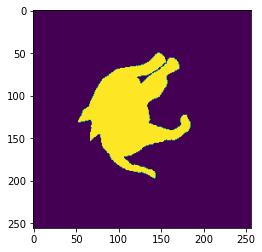

In [322]:
plt.imshow(test_rot)

In [32]:
acc_list = []
for i,batch in enumerate(test_dataloader):
    imgs,labels = batch
    rot_imgs = torch.tensor(rotate_img(imgs))
    rot_imgs = rot_imgs.to('cuda:0'); labels = labels.to('cuda:0')
    pcs= make_pointclouds(rot_imgs)
    with torch.no_grad():
        encoding = enc_model(pcs.permute(0,2,3,1))
        pred_labels = dec_model(encoding)
    acc_list.append(torch.mean((pred_labels.argmax(1) == labels).cpu().to(torch.float)))
print(np.mean(acc_list))

0.36


In [287]:
rot_imgs.shape

torch.Size([50, 1, 256, 256])

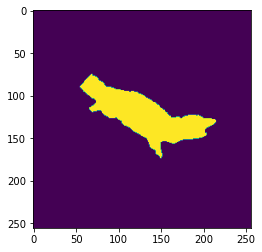

In [324]:
plt.imshow(rot_imgs[0,0,...].cpu())

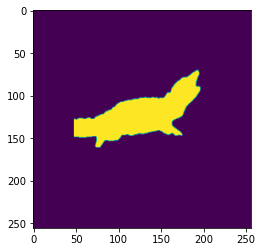

In [325]:
plt.imshow(imgs[0,0,...])